In [1]:
import torch 
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR 
import torchvision.transforms.functional as F

import numpy as np
import os
import sys
import json
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from tqdm import tqdm

# pv_vision_dir = os.path.join(Path.home(), 'pv-vision')
pv_vision_dir = os.path.join('/home/eccoope', 'pv-vision')
# functions_dir = os.path.join(Path.home(), 'el_img_cracks_ec', 'scripts')
functions_dir = os.path.join('/home/eccoope', 'el_img_cracks_ec', 'scripts')

sys.path.append(pv_vision_dir)
sys.path.append(functions_dir)

# ojas_functions_dir = os.path.join(Path.home(), 'pvcracks/retrain/')
ojas_functions_dir = '/Users/ojas/Desktop/saj/SANDIA/pvcracks/retrain/'
sys.path.append(ojas_functions_dir)

from tutorials.new_unet_model import construct_unet
import functions

In [2]:
# root = Path('/projects/wg-psel-ml/EL_images/osanghi/CornersIHDEANE/')
# root = Path('/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/CornersIHDEANE/')
# root = Path('/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Norman_LineCorners/')
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/LineCorners_With_Original/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/CWRU_SunEdison_Mono/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/CWRU_Dupont_Mono/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_SunEdison_and_Dupont_Mono/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/LBNL_Mono_Cells/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_SE_Dupont_and_LBNL_Mono/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_LBNL_ASU_No_Busbar/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_LBNL_ASU_Overlap/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_LBNL_ASU_Combined_Overlap_NoOverlap/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_ASU/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/CWRU_Dupont_Mono_ContinuousCracks/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_ASU_ContinuousCracks/"
root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Channeled_ASU/"


model_weight_paths = {
    "emma_retrained": "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/retrained_pv-vision_model.pt",
    "original": "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/pv-vision_model.pt",
}

# weight_path = model_weight_paths["emma_retrained"]
weight_path = model_weight_paths["original"]

# checkpoint_name = "line_corners_og_weights_checkpoint"
# checkpoint_name = "CWRU_SunEdison_Mono"
# checkpoint_name = "CWRU_Dupont_Mono"
# checkpoint_name = "Combined_CWRU_SunEdison_and_Dupont_Mono"
# checkpoint_name = "LBNL_Mono_Cells"
# checkpoint_name = "Combined_CWRU_LBNL_ASU_No_Busbar"
# checkpoint_name = "Combined_CWRU_LBNL_ASU_Overlap"
# checkpoint_name = "Combined_CWRU_LBNL_ASU_Combined_Overlap_NoOverlap"
# checkpoint_name = "Combined_CWRU_ASU"
# checkpoint_name = "CWRU_Dupont_Mono_ContinuousCracks"
# checkpoint_name = "Combined_CWRU_ASU_ContinuousCracks"
checkpoint_name = root.split("/")[-2]

In [3]:
def load_dataset(root):
    # transformers = functions.Compose([functions.FixResize(256), functions.ToTensor(), functions.Normalize()])
    transformers = functions.Compose([functions.NewFixResize(256), functions.ToTensor(), functions.Normalize()])
    
    train_dataset = functions.SolarDataset(root, image_folder="img/train", 
            mask_folder="ann/train", transforms=transformers)
    
    val_dataset = functions.SolarDataset(root, image_folder="img/val", 
            mask_folder="ann/val", transforms=transformers)

    return train_dataset, val_dataset

In [4]:
def load_device_and_model(weight_path):
    # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    device = torch.device("mps")
    unet = construct_unet(5)
    unet = torch.nn.DataParallel(unet)
    
    model = unet.module.to(device)
    
    return device, model

In [5]:
def get_save_dir(base_dir, checkpoint_name):
    checkpoint_dir = base_dir + "/checkpoints/"
    folders = [folder for folder in os.listdir(checkpoint_dir)]
    
    max_number = 0
    for folder in folders:
        number = int(folder[-1])
        if number > max_number:
            max_number = number

    new_folder_name = f"{checkpoint_name}{max_number + 1}"
    new_folder_path = os.path.join(checkpoint_dir, new_folder_name)
    
    os.makedirs(new_folder_path, exist_ok=True)
    
    return new_folder_path

In [6]:
train_dataset, val_dataset = load_dataset(root)
device, model = load_device_and_model(weight_path)

train_loader = DataLoader(train_dataset, shuffle=True)
val_loader = DataLoader(val_dataset, shuffle=False)

In [7]:
category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "non-cell"}

In [24]:
import matplotlib.pyplot as plt

def new_inference_and_show(idx, threshold=0.5):
    # Get the preprocessed image and multi-hot ground truth mask
    img, mask = train_loader.dataset.__getitem__(idx)
    img = img.to(device)
    
    # Get the raw image for display (assuming __getraw__ returns a PIL image)
    raw_img, _ = train_loader.dataset.__getraw__(idx)
    
    # --- Run inference ---
    # Get raw logits from the model, then apply Sigmoid and threshold
    logits = model(img.unsqueeze(0)).detach().cpu()  # shape: [1, 5, H, W]
    probs = torch.sigmoid(logits)                     # shape: [1, 5, H, W]
    pred_mask = (probs > threshold).float().squeeze(0).numpy()  # shape: [5, H, W]
    
    # Ground truth is assumed to be already a 5-channel multi-hot mask.
    gt_mask = mask.cpu().numpy()  # shape: [5, H, W]
    
    # --- Visualization ---
    # Create a grid with 3 rows and 5 columns:
    #   Row 0: Raw image (displayed only once in the first column)
    #   Row 1: Ground truth masks for each class
    #   Row 2: Predicted masks for each class
    n_classes = 5
    class_names = [f'({k}) {v}' for k, v in category_mapping.items()]
    
    fig, axs = plt.subplots(3, n_classes, figsize=(4*n_classes, 12))
    
    # Row 0: Display raw image in first subplot; hide other subplots in this row.
    axs[0, 0].imshow(raw_img.convert('L'), cmap='viridis')
    axs[0, 0].set_title("Raw Image")
    axs[0, 0].axis('off')
    for j in range(1, n_classes):
        axs[0, j].axis('off')
    
    # Row 1: Ground truth for each class (each channel)
    for j in range(n_classes):
        axs[1, j].imshow(gt_mask[j], cmap='viridis')
        axs[1, j].set_title(f"GT: {class_names[j]}")
        axs[1, j].axis('off')
    
    # Row 2: Predictions for each class (each channel)
    for j in range(n_classes):
        axs[2, j].imshow(pred_mask[j], cmap='viridis')
        axs[2, j].set_title(f"Pred: {class_names[j]}")
        axs[2, j].axis('off')
    
    fig.suptitle("Retrained Model Prediction", fontsize=16)
    
    plt.tight_layout()
    plt.show()

# Training

In [10]:
batch_size_val=1
batch_size_train=1
lr = 0.000001
step_size=1
gamma = 0.1
num_epochs = 30
criterion = torch.nn.BCEWithLogitsLoss()

save_dir = get_save_dir(str(root), checkpoint_name)
os.makedirs(save_dir, exist_ok=True)

params_dict = {'batch_size_val' : batch_size_val,
           'batch_size_train' : batch_size_train,
           'lr' : lr,
           'step_size' : step_size,
           'gamma' : gamma,
           'num_epochs' : num_epochs,
           'criterion' : str(criterion)}

with open(os.path.join(save_dir, 'params.json'), 'w', encoding='utf-8') as f:
    json.dump(params_dict, f, ensure_ascii=False, indent=4)

In [11]:
optimizer = Adam(model.parameters(), lr=lr)
lr_scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
evaluate_metric=None
running_record = {'train': {'loss': []}, 'val': {'loss': []}}

save_name='model.pt'
cache_output = True

In [12]:
training_epoch_loss = []
val_epoch_loss = []

for epoch in tqdm(range(1, num_epochs + 1)):
    
    training_step_loss = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        target = target.float()
        
        optimizer.zero_grad()
        
        # forward pass
        output = model(data)
        
        # calc loss -- bce with logits loss applies sigmoid interally
        training_loss = criterion(output, target)
        
        #backward pass
        training_loss.backward()
        optimizer.step()
        
        # record loss
        training_step_loss.append(training_loss.item())
        
    training_epoch_loss.append(np.array(training_step_loss).mean())

    val_step_loss = []
    
    for batch_idx, (data, target) in enumerate(val_loader):
        data, target = data.to(device), target.to(device)
        target = target.float()
        
        # forward pass
        data = data.to(device)
        
        output = model(data)
        
        # calc loss -- bce with logits loss applies sigmoid interally
        val_loss = criterion(output, target)
        
        val_step_loss.append(val_loss.item())
        
    val_epoch_loss.append(np.array(val_step_loss).mean())
    
    os.makedirs(os.path.join(save_dir, f'epoch_{epoch}'), exist_ok=True)
    torch.save(model.state_dict(), os.path.join(save_dir, f'epoch_{epoch}', save_name))
    print(f'Saved model at epoch {epoch}')

  3%|▎         | 1/30 [00:40<19:46, 40.90s/it]

Saved model at epoch 1


  7%|▋         | 2/30 [01:20<18:44, 40.16s/it]

Saved model at epoch 2


 10%|█         | 3/30 [02:00<17:58, 39.93s/it]

Saved model at epoch 3


 13%|█▎        | 4/30 [02:39<17:15, 39.84s/it]

Saved model at epoch 4


 17%|█▋        | 5/30 [03:19<16:36, 39.85s/it]

Saved model at epoch 5


 20%|██        | 6/30 [04:00<15:59, 39.99s/it]

Saved model at epoch 6


 23%|██▎       | 7/30 [04:42<15:37, 40.77s/it]

Saved model at epoch 7


 27%|██▋       | 8/30 [05:22<14:55, 40.71s/it]

Saved model at epoch 8


 30%|███       | 9/30 [06:03<14:14, 40.68s/it]

Saved model at epoch 9


 33%|███▎      | 10/30 [06:44<13:32, 40.62s/it]

Saved model at epoch 10


 37%|███▋      | 11/30 [07:24<12:52, 40.66s/it]

Saved model at epoch 11


 40%|████      | 12/30 [08:06<12:15, 40.87s/it]

Saved model at epoch 12


 43%|████▎     | 13/30 [08:46<11:33, 40.80s/it]

Saved model at epoch 13


 47%|████▋     | 14/30 [09:27<10:52, 40.77s/it]

Saved model at epoch 14


 50%|█████     | 15/30 [10:08<10:11, 40.77s/it]

Saved model at epoch 15


 53%|█████▎    | 16/30 [10:49<09:30, 40.75s/it]

Saved model at epoch 16


 57%|█████▋    | 17/30 [11:31<08:58, 41.41s/it]

Saved model at epoch 17


 60%|██████    | 18/30 [12:12<08:13, 41.13s/it]

Saved model at epoch 18


 63%|██████▎   | 19/30 [12:52<07:30, 40.96s/it]

Saved model at epoch 19


 67%|██████▋   | 20/30 [13:33<06:48, 40.86s/it]

Saved model at epoch 20


 70%|███████   | 21/30 [14:14<06:07, 40.84s/it]

Saved model at epoch 21


 73%|███████▎  | 22/30 [14:56<05:29, 41.16s/it]

Saved model at epoch 22


 77%|███████▋  | 23/30 [15:38<04:49, 41.38s/it]

Saved model at epoch 23


 80%|████████  | 24/30 [16:20<04:09, 41.53s/it]

Saved model at epoch 24


 83%|████████▎ | 25/30 [17:02<03:29, 41.90s/it]

Saved model at epoch 25


 87%|████████▋ | 26/30 [17:45<02:48, 42.09s/it]

Saved model at epoch 26


 90%|█████████ | 27/30 [18:27<02:06, 42.06s/it]

Saved model at epoch 27


 93%|█████████▎| 28/30 [19:10<01:24, 42.26s/it]

Saved model at epoch 28


 97%|█████████▋| 29/30 [19:52<00:42, 42.42s/it]

Saved model at epoch 29


100%|██████████| 30/30 [20:35<00:00, 41.17s/it]

Saved model at epoch 30


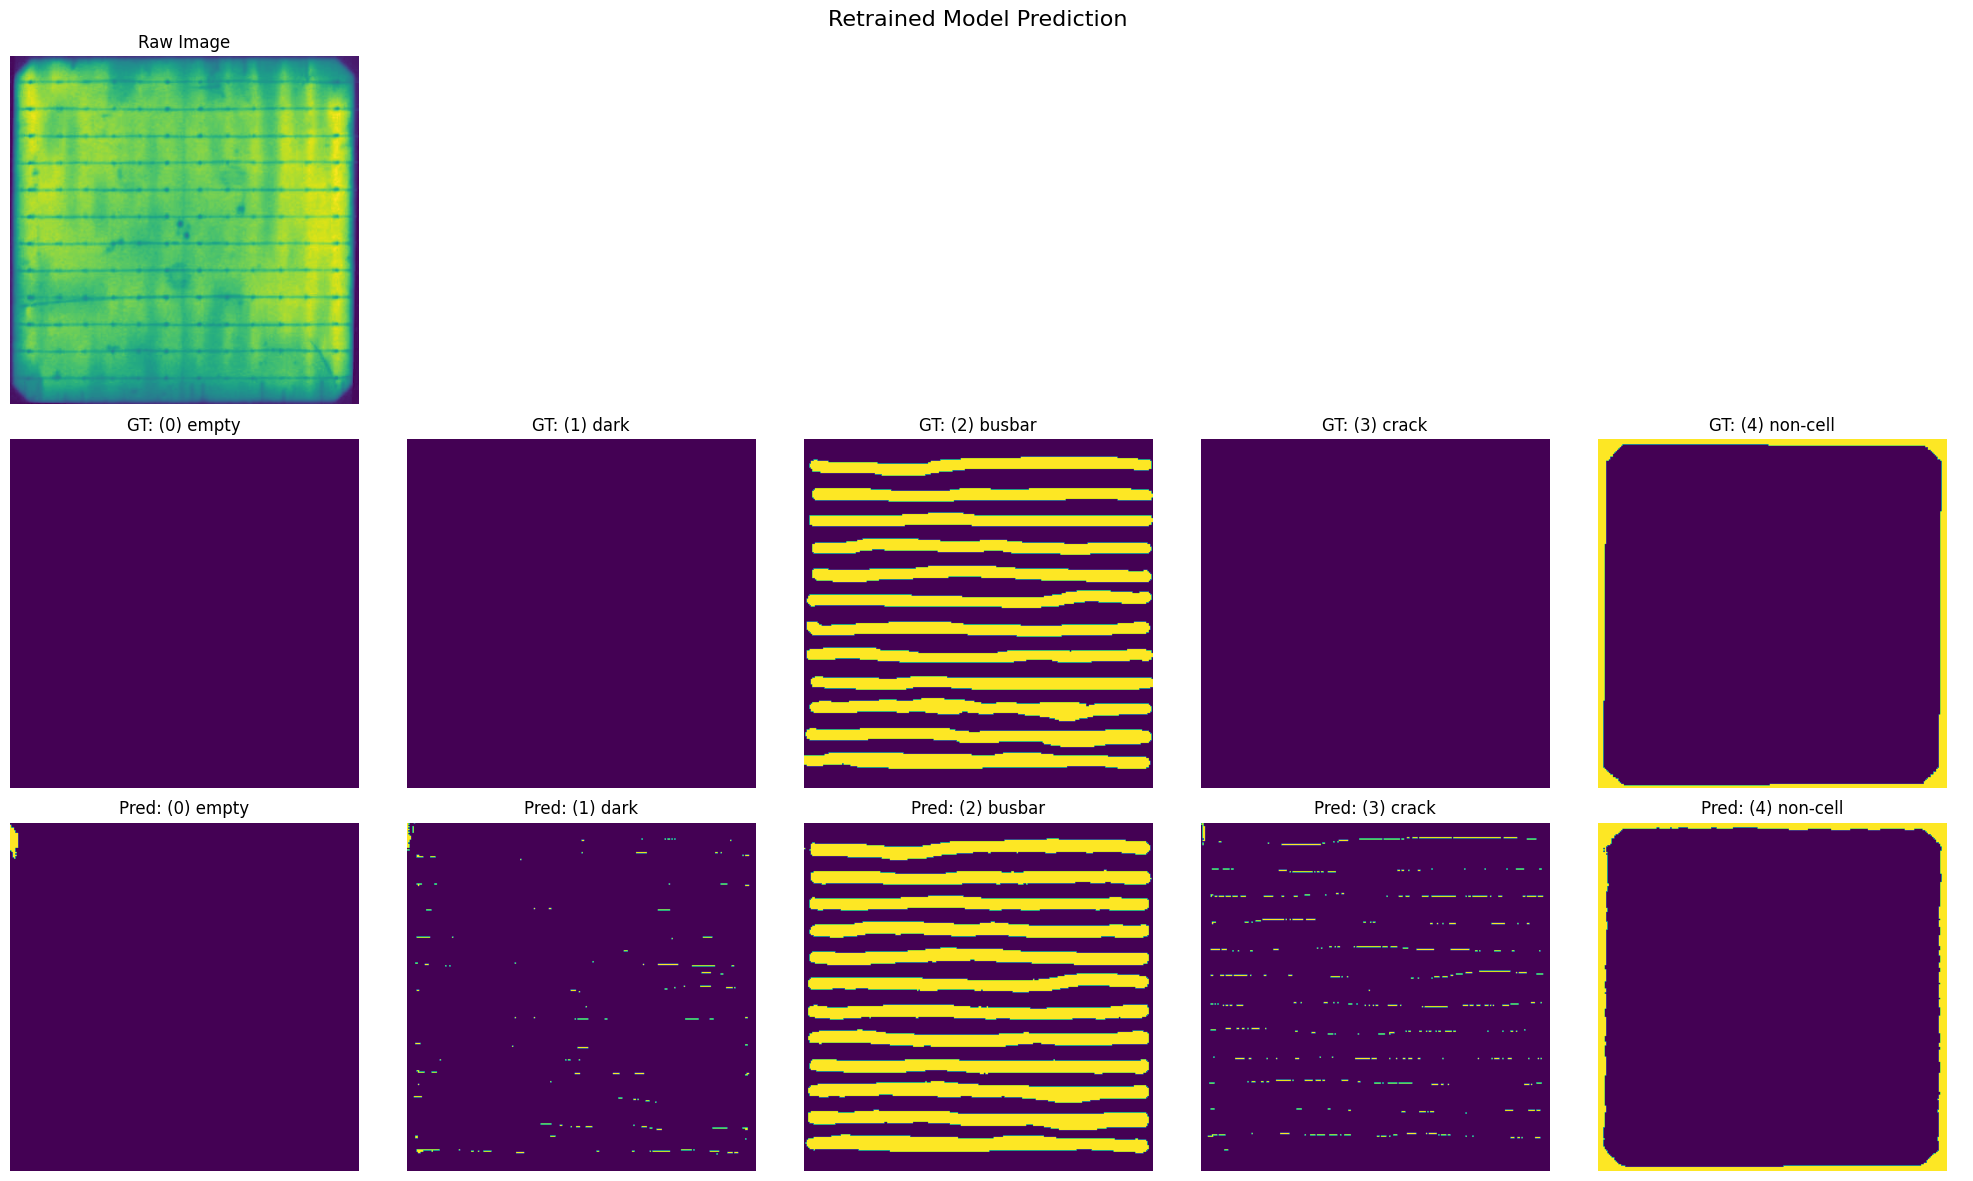

In [27]:
new_inference_and_show(-32)

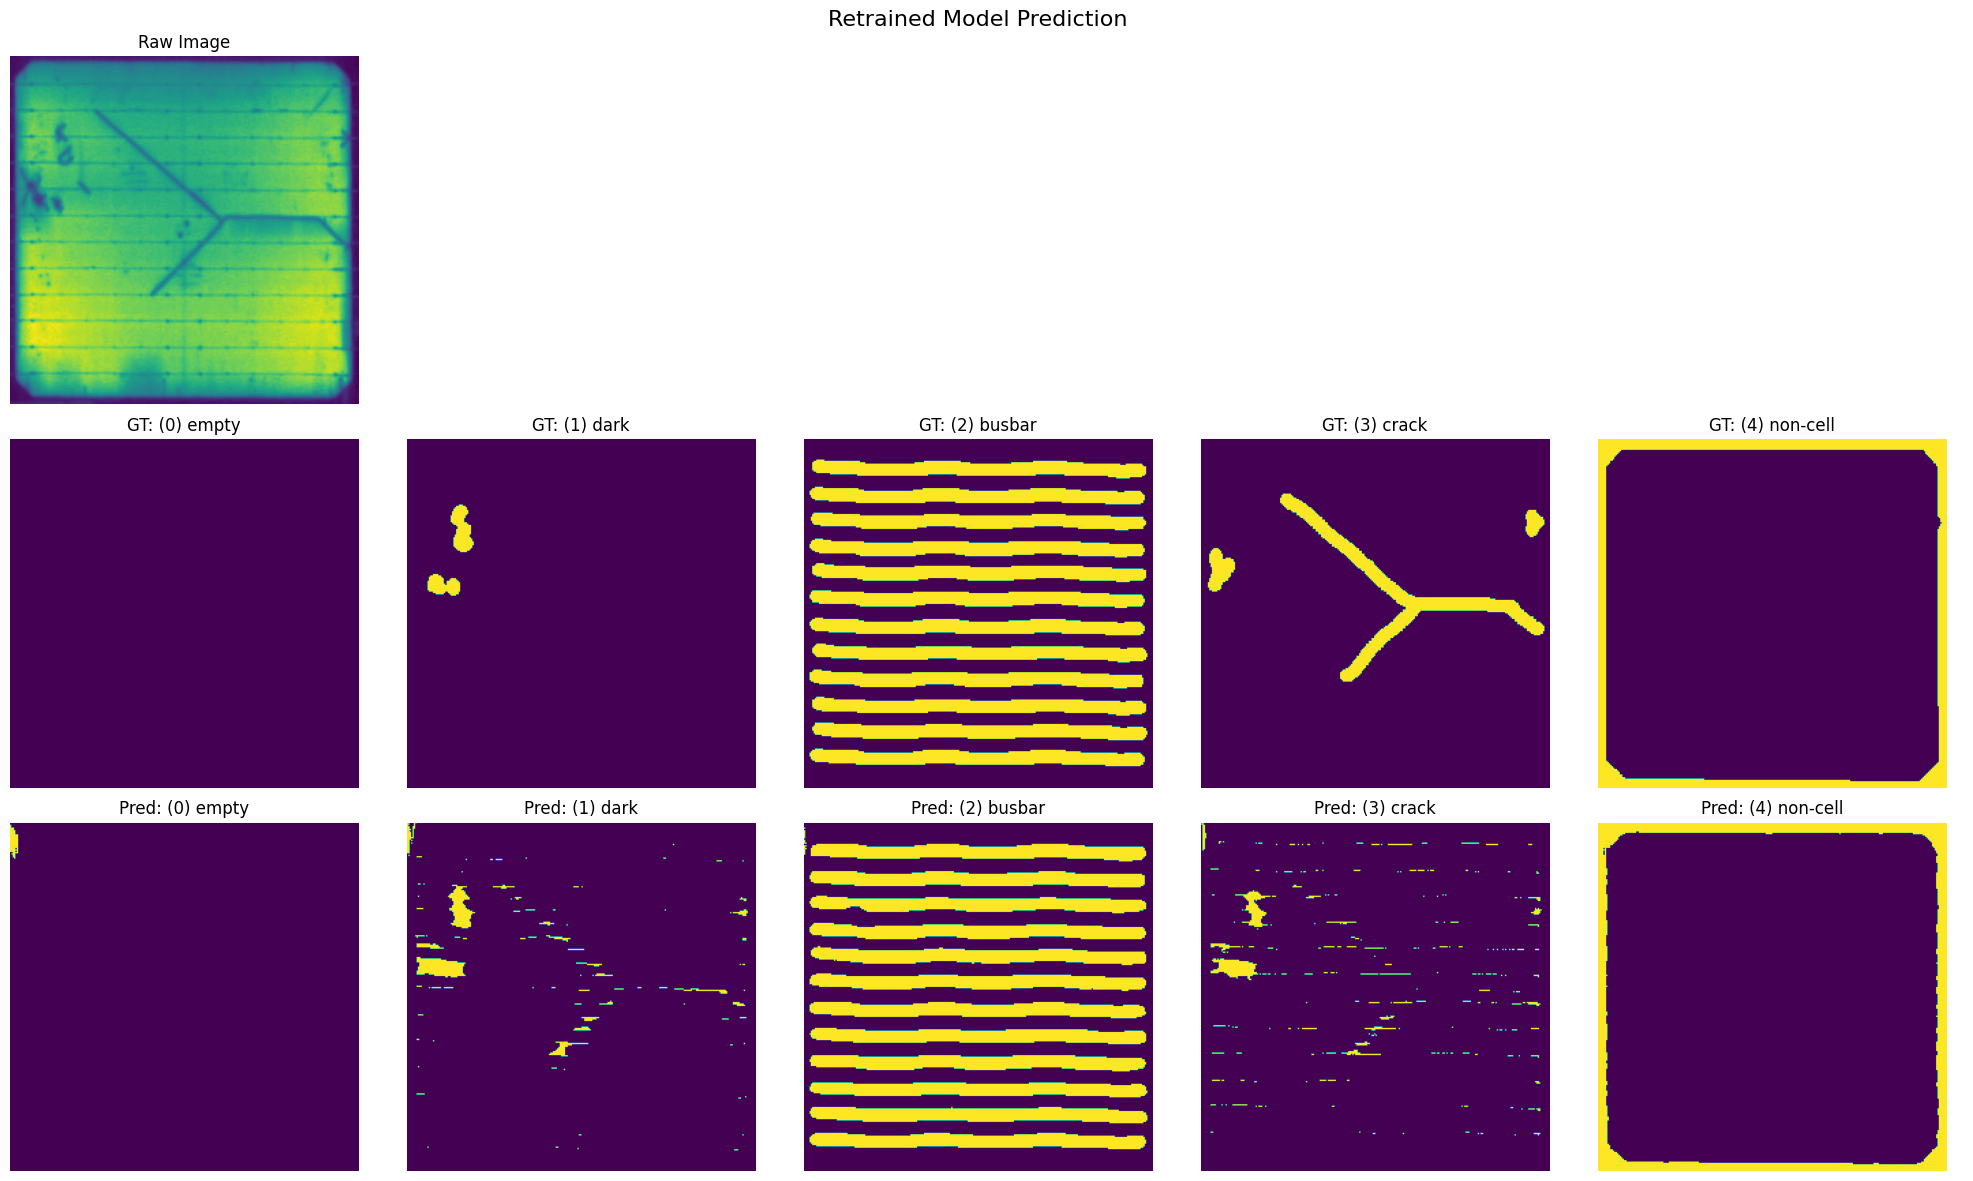

In [28]:
new_inference_and_show(13)

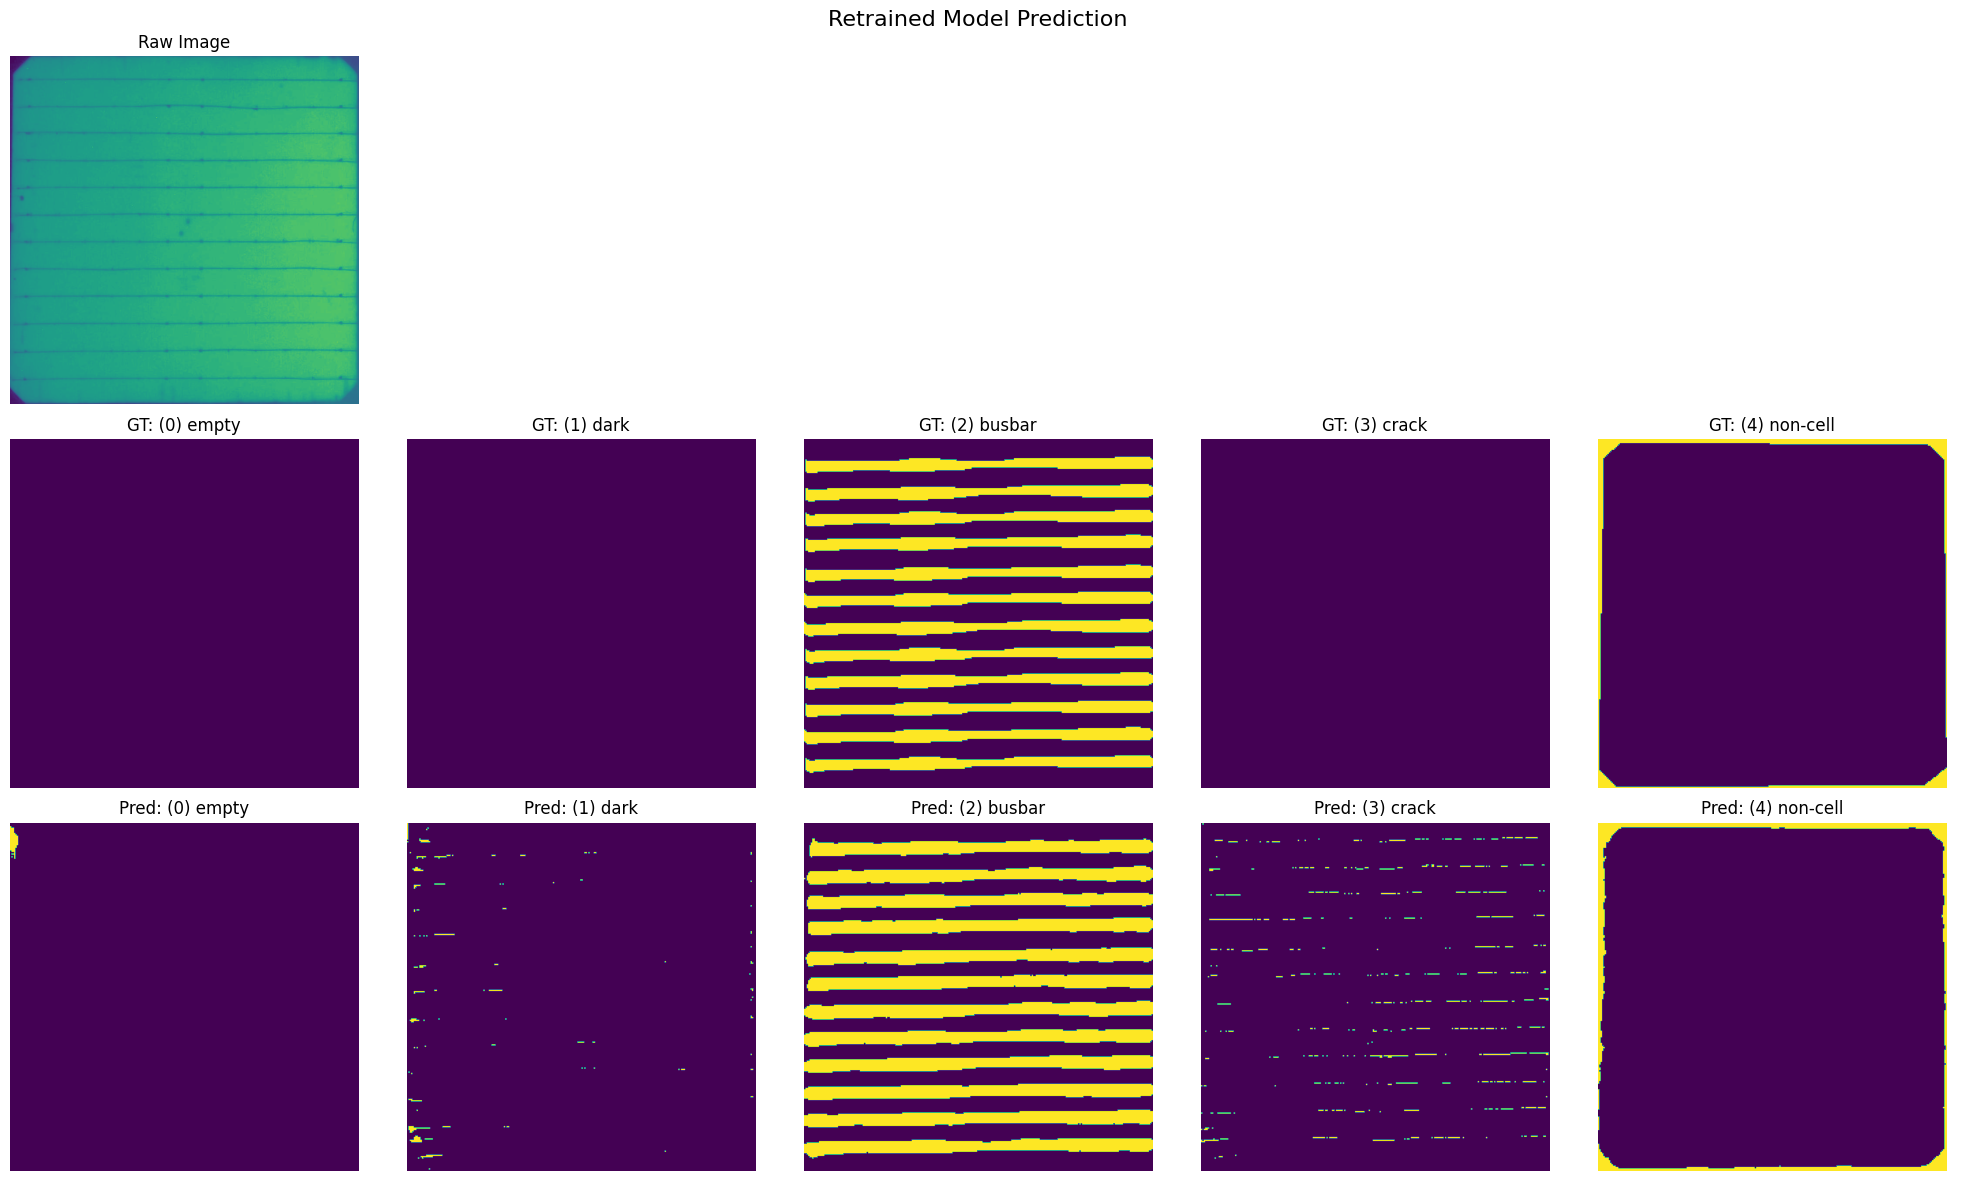

In [29]:
new_inference_and_show(44)

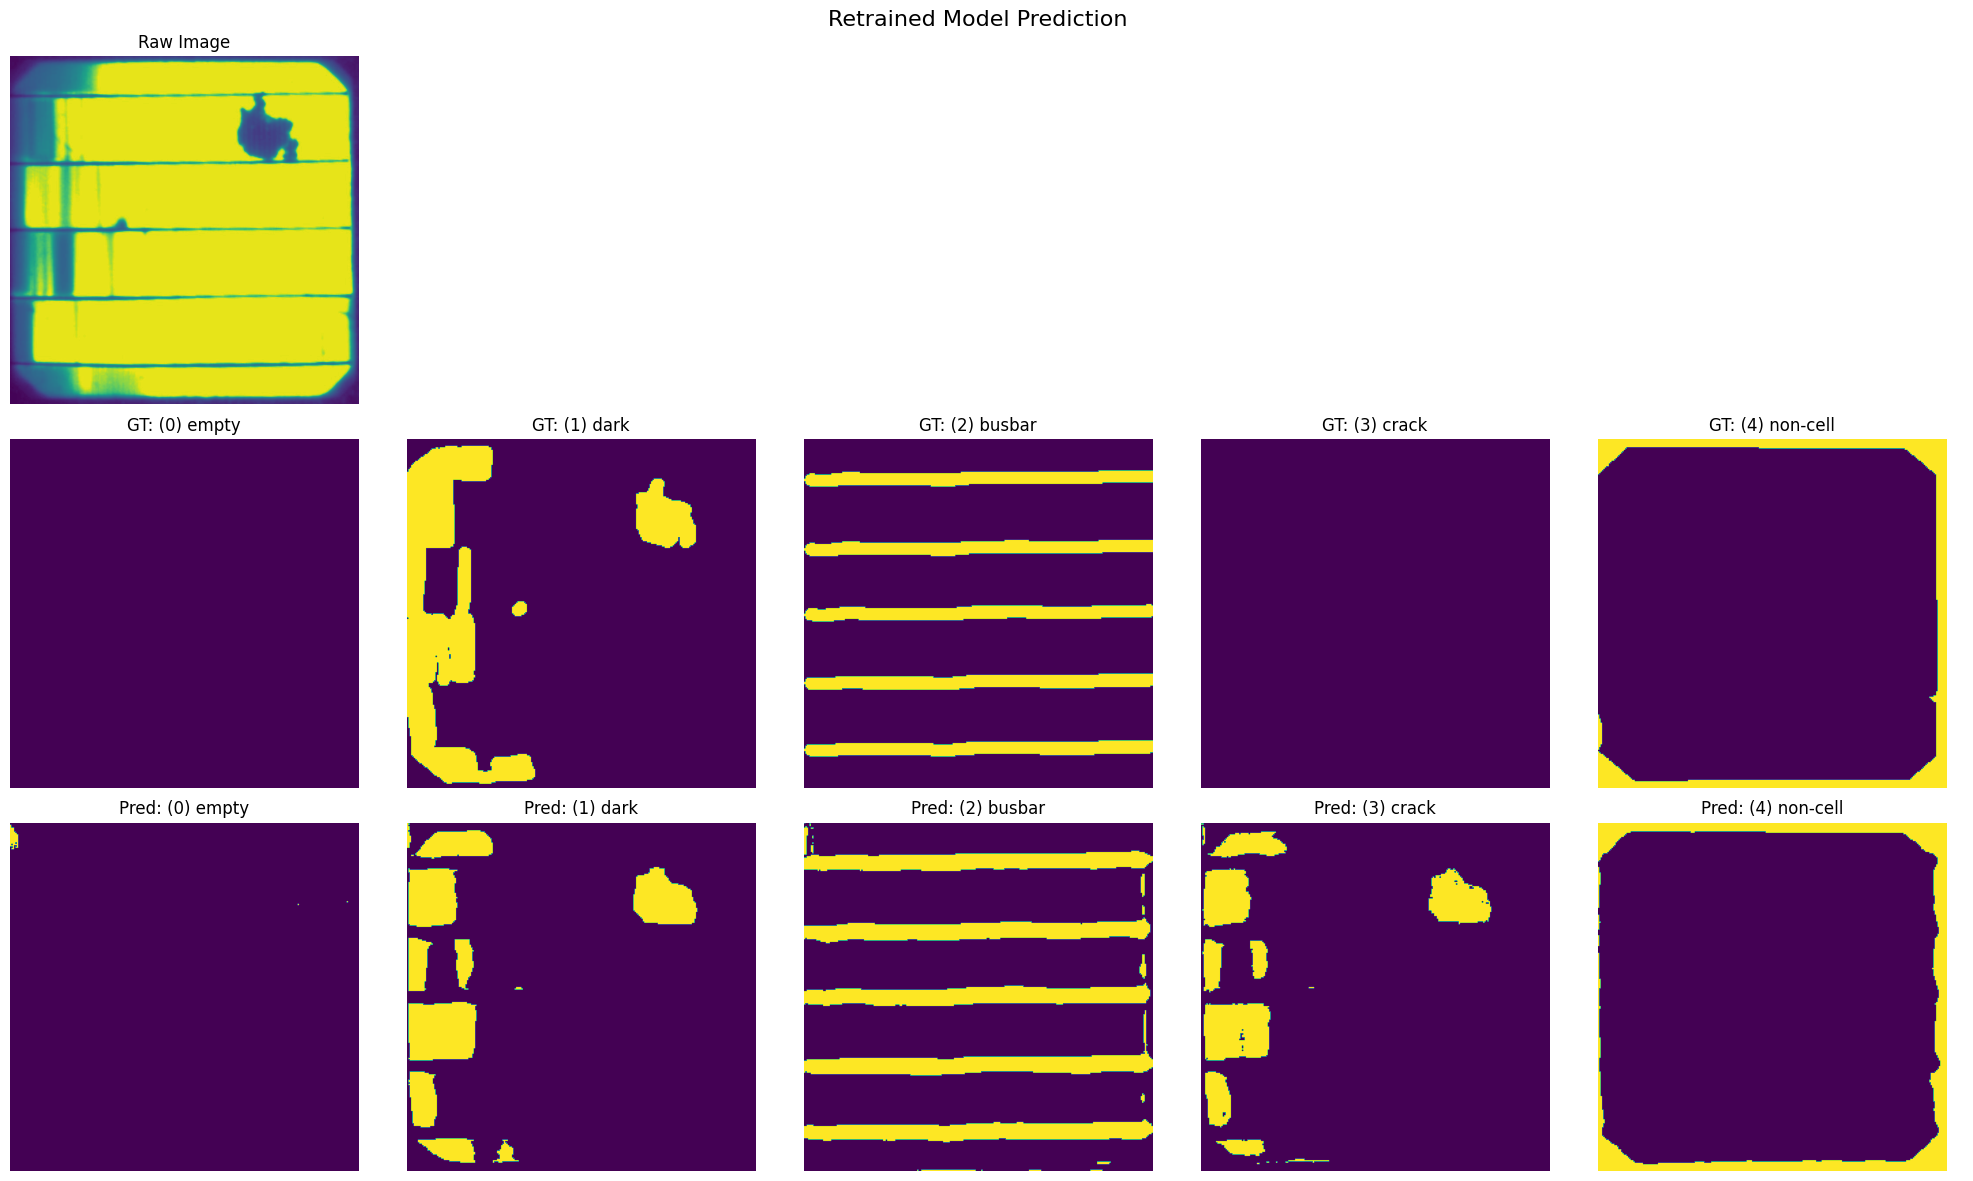

In [30]:
new_inference_and_show(1)

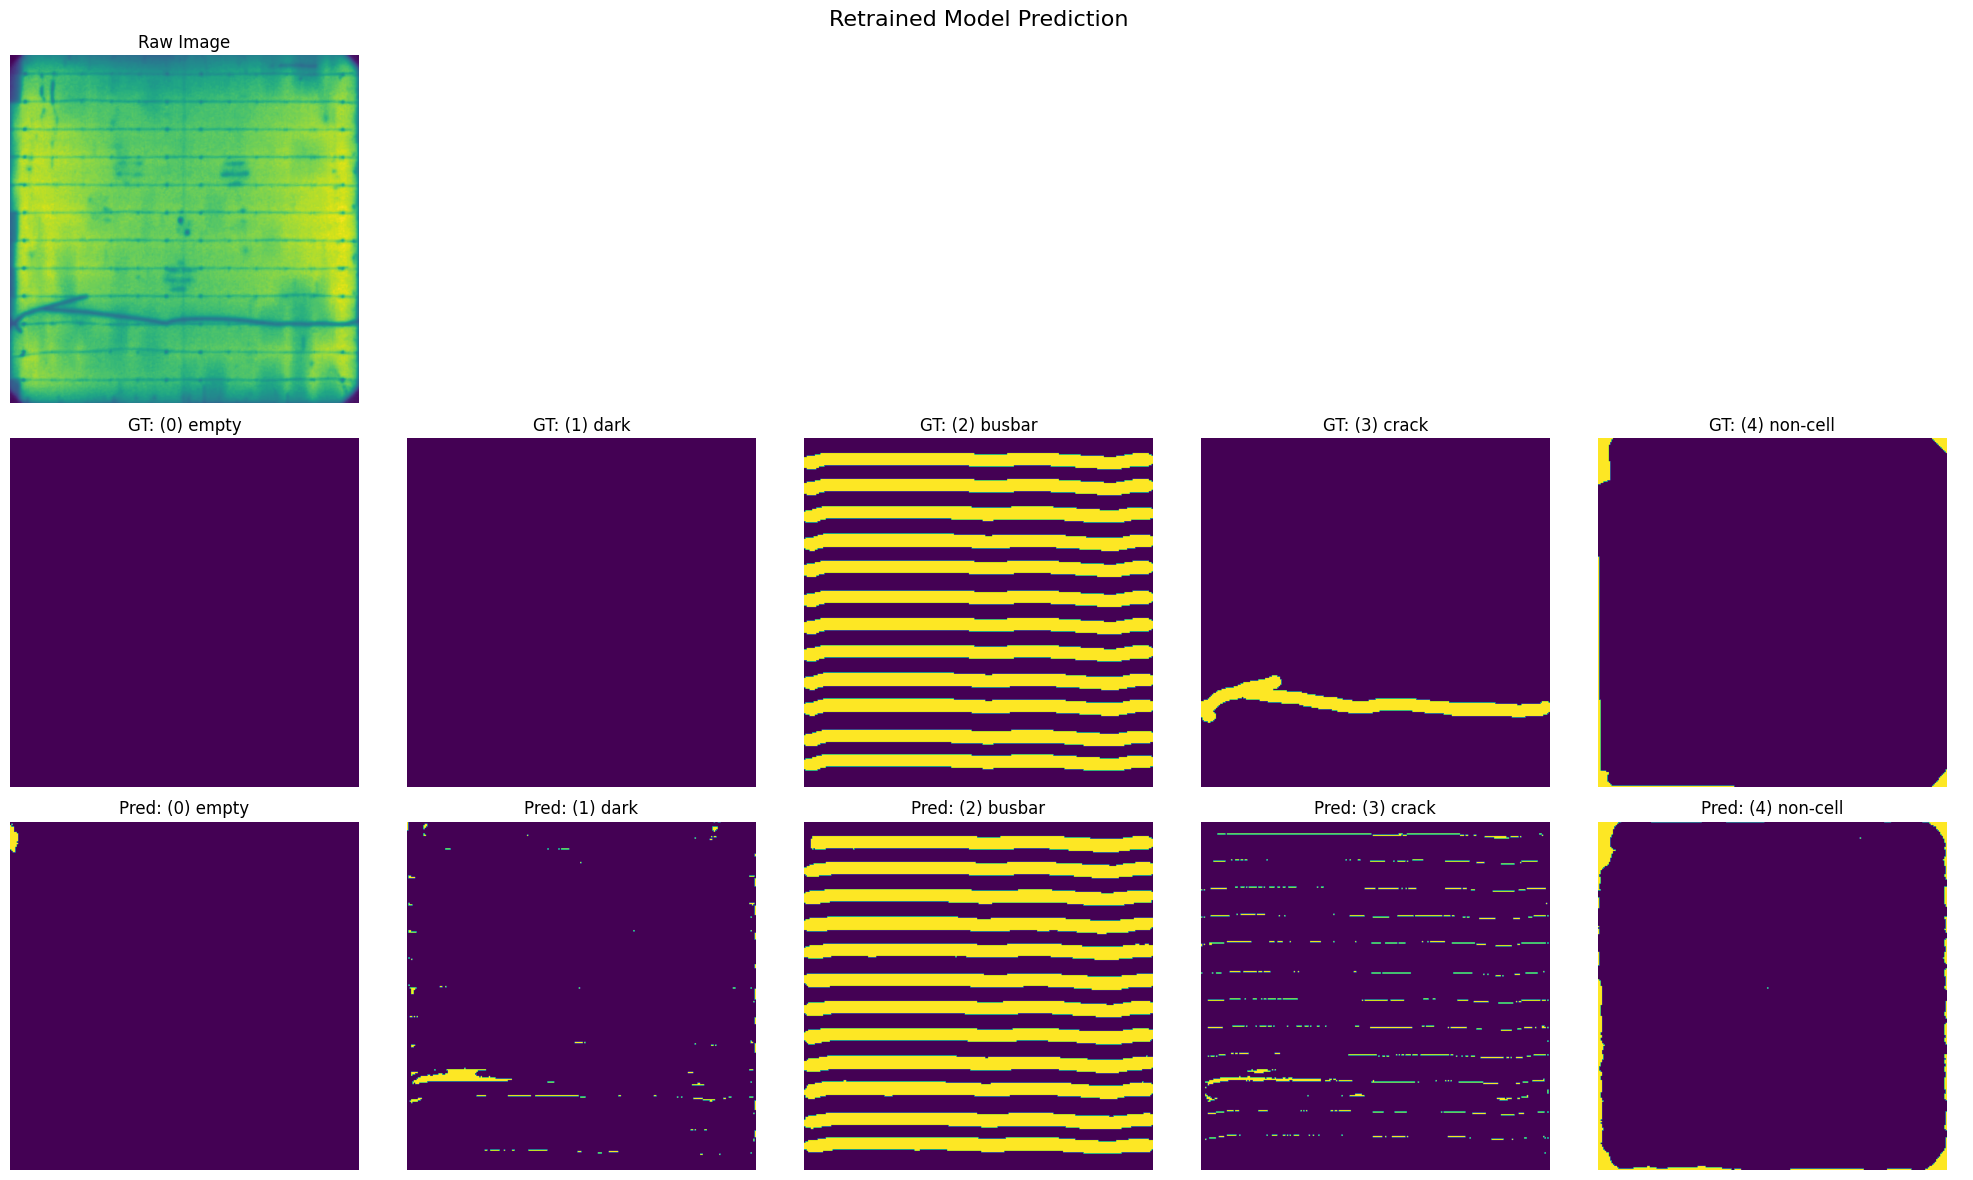

In [31]:
new_inference_and_show(6)

In [ ]:
# for i in range(500):
#     inference_and_show(i, retrained=True)

In [ ]:
fig, ax = plt.subplots()

x = np.arange(1, len(training_epoch_loss) + 1, 1)

ax.scatter(x, training_epoch_loss, label='training loss')
ax.scatter(x, val_epoch_loss, label='validation loss')
ax.legend()
ax.set_xlabel('Epoch')

print(training_epoch_loss)


In [ ]:
val_epoch_loss